In [29]:
import PIL
import os
import numpy as np
import scipy
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [30]:
for folder in os.listdir('../data'):
    print(folder, len(os.listdir(os.path.join('../data', folder))))

.ipynb_checkpoints 0
photo_jpg 7038
monet 1


In [31]:
def view_images(folder = '../data/photo_jpg'):
    for i in os.listdir(folder):
        img2 = PIL.Image.open(os.path.join(folder, i))
        #size of the images
        img_array = np.array(img2)
        print(img_array.shape)
        yield img2
photo_generator = view_images()

(256, 256, 3)


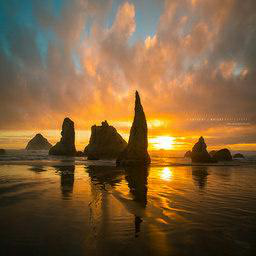

In [32]:
next(photo_generator)

In [33]:
monet_generator = view_images('../data/monet/monet_jpg')

(256, 256, 3)


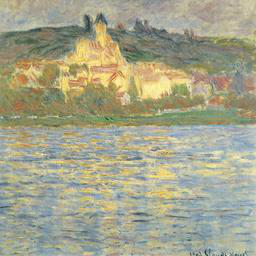

In [34]:
next(monet_generator)

In [35]:
#deal with CNNs
!nvidia-smi

Tue Jul  6 03:42:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.130      Driver Version: 418.130      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID V100DX-8Q      On   | 00000000:00:06.0 Off |                  N/A |
| N/A   N/A    P0    N/A /  N/A |   1737MiB /  8192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [120]:
#image data generator
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

dataset = dset.ImageFolder('../data/monet', transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()]))
dataloader = DataLoader(dataset, batch_size = 30, shuffle = True)
device = torch.device('cuda:0')

In [121]:
dataset

Dataset ImageFolder
    Number of datapoints: 300
    Root location: ../data/monet
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [122]:
nz = 100
ngf = 64
nc = 3
ndf = 64

In [123]:
#build a generator (U-Net) and a discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, hidden_layer, hidden_layer2):
        super(Discriminator, self).__init__()
        self.conv2d_4x4 = nn.Conv2D(3, 16, 4, stride = 2, padding = 1, bias = False) #16 by 127 by 127
        self.conv2d_4x4_2 = nn.Conv2D(16, 32, 4, stride = 2) #
        self.conv2d_3x3 = nn.Conv2D(32, 64, 3, stride = 1)
        self.avgpooling = nn.AvgPool2D(2)
        self.maxpool = nn.MaxPool2D(2)
        self.activation = nn.ReLU()
        self.dense = nn.LazyLinear(hidden_layer)
        self.dense2 = nn.Linear(hidden_layer, hidden_layer2)
        self.linear_activation = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.AvgPooling1d = nn.AvgPool1d()
        
    def forward(self, inputs):
        out = self.conv2d_4x4(inputs) # 3 by 256 by 256 -> 16 act maps x 127 by 127
        out = self.activation(out) # 16 x 127 x 127
        out = self.maxpool(out) # 
        out = self.conv2d_5x5_2(out)
        out = self.maxpool(out)
        out = self.activation(out)
        out = self.conv2d_3x3(out)
        out = self.avgpooling(out)
        out = self.activation(out)
        out = nn.Flatten(out)
        
        out = self.dense(out)
        out = self.linear_activation(out)
        out = self.dense2(out)
        out = self.linear_activation(out)
        out = self.AvgPooling1d(out)
        return self.sigmoid(out)
        
    
class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.discriminator = Discriminator()
        self.generator = Generator()
        
    def forward(self, inputs):
        pass

In [124]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #32 by 1 by 13 by 13
            
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [125]:
g = Generator()
d = Discriminator()

In [126]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
g.apply(weights_init)
d.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [127]:
g.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [128]:
d.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [129]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(256, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
lr = 0.001
beta1 = 0.5
optimizerD = optim.Adam(d.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(g.parameters(), lr=lr, betas=(beta1, 0.999))

In [132]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 30

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        d.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        print(real_cpu.shape)
        b_size = real_cpu.size(0) #batch size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        output = d(real_cpu).view(-1,1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = g(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = d(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        g.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = d(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = g(fixed_noise).detach().cpu()

        iters += 1

Starting Training Loop...
torch.Size([30, 3, 64, 64])
[0/30][0/10]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
[1/30][0/10]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
[2/30][0/10]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])


torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
[23/30][0/10]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
[24/30][0/10]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
torch.Size([30, 3, 64, 64])
[25/30][0/10]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
torch.Size([30, 3, 64, 

In [10]:
#Create FID metrics
#Step 1: Initialize an Inception_V3 model
#inception = inception_v3(pretrained = True)

In [40]:
import torch.nn as optim

ModuleNotFoundError: No module named 'torch.nn.optim'

In [13]:
#inception.eval()
#tensors = inception(next(iter(dataloader))[0])

In [10]:
#to extract features from inception, we need to rebuild the model.
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import inception_v3

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        """Build pretrained InceptionV3
        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradient. Possibly useful
            for finetuning the network
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0.0, 1.0)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [11]:
v3 = InceptionV3()

In [12]:
v3.eval()
tensors = v3(next(iter(dataloader))[0])

In [13]:
tensors[0][0].numpy().squeeze()

array([0.21610442, 0.57545817, 0.4293099 , ..., 0.5618698 , 0.05171571,
       0.5468621 ], dtype=float32)

In [29]:
#define FID
#A and B are two 2048 size vectors
def calculate_FID_distance(A, B):
    mu_A = np.mean(A, axis = 0)
    mu_B = np.mean(B, axis = 0)
    cov_A = np.cov(A, rowvar=False)
    cov_B = np.cov(B, rowvar = False)
    covmean = scipy.linalg.sqrtm(cov_A.dot(cov_B))
    ssq = np.sum(np.square(mu_A-mu_B))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    return ssq + np.trace(cov_A+cov_B-2*covmean)

In [18]:
def calculate_d_ij(real_vec, gen_vec):
    return 1 - np.dot(real_vec, gen_vec)/(np.linalg.norm(real_vec)*np.linalg.norm(gen_vec))

def calculate_memorization(gen_matrix, real_matrix, eps):
    #dimension of real: M*2048, gen: N*2048
    #final score matrix: N*M (gen by real)
    score = np.zeros(gen_matrix.shape[0], real_matrix.shape[0])
    #e.g 3 by 2048
    for i in range(gen_matrix.shape[0]):
        for j in range(real_matrix.shape[0]):
            score[i,j] = calculate_dij(real_matrix[j,:], gen_matrix[i:])
    
    #average all the generated images
    d = np.mean(np.min(score, axis=0))
    if d < eps:
        dthr = d
    else:
        dthr = 1
    
    return dthr
    
def get_mifid(gen_matrix, real_matrix, eps = 10e-15):
    d = calculate_FID_distance(gen_matrix)
    calculate_memorization(gen_matrix, real_matrix, eps)
    

1e-15

In [14]:
act1 = np.random.random(10*2048)
act1 = act1.reshape((10,2048))
act2 = np.random.random(10*2048)
act2 = act2.reshape((10,2048))

In [17]:
calculate_d_ij(act1[0,:], act2[0,:])

0.2475994974027821

In [50]:
calculate_FID_distance(act1, act2)

0.0014981541271774622

In [40]:
calculate_FID_distance(tensors[0].numpy().squeeze(), tensors[0].numpy().squeeze())

4.85722573273506e-16

$$FID^2 = ||\mu_1 – \mu_2||^2 + Tr(C_1 + C_2 – 2*sqrt(C_1*C_2))$$

$$d_{ij} = 1 - cos = 1 - \frac{f_{gi} \cdot f_{rj}}{|f_{gi}| |f_{rj}|}$$

$$d = \frac{1}{N} \sum_{i} \min_j d_{ij}$$

$$ d_{thr} = \begin{cases}  d \text{ if d} < \epsilon \\ 1 \text{ otherwise} \end{cases}$$

$$ MiFID = FID \cdot \frac{1}{d_{thr}} $$